In [1]:
import pyro
import torch
import gpytorch
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/spatial-indian-buffet-process/data/16APR2025.h5ad")
adata = adata[adata.obs["cell_type"].eq("Astrocyte") & adata.obs["folder"].eq("99-15")]

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
import torch
import numpy as np
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata, specimen_name: str = "folder"):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].layers["transcript"])
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    folder = torch.tensor(pd.Categorical(adata.obs[specimen_name]).codes).float()
    return X, size_factor, folder

X, size_factor, folder = setup_torch_data(adata, specimen_name="folder")

X = X.to(device)
size_factor = size_factor.to(device)
folder = folder.to(device)
locs = torch.tensor(adata.obs[["x_centroid", "y_centroid"]].values).to(device)
group_assignments = torch.zeros(X.shape[0])

In [3]:
import sys
sys.path.append("..")

In [4]:
import importlib

import src.model
importlib.reload(src.model)

<module 'src.model' from '/home/jhaberbe/Projects/spatial-indian-buffet-process/notebook/../src/model.py'>

In [5]:
sibp = src.model.SpatialIndianBuffetProcess(adata=adata[:, (adata.X > 0).mean(axis=0) > 0.05], length_scale=100)

In [16]:
sibp.fit(
    coordinates = locs,
    count_matrix = X,
    group_assignments = folder,
    num_steps = 40_000,
    wandb_kwargs = {
        "project": "sibp",
        "name": "kanna-chameleon"
    },
    clear_param_store = False
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[39999] ELBO loss: 887149.19


feature_sparsity,██▇▇▆▄▅▄▄▄▄▄▃▃▃▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂
loss,▁▃▂▂▆▃▁▃▃▂▃▃▄▂▂▂▄▃▂▃▂▃▃▃▃▄▂▆▂▄▄█▄▂▂▄▄▄▆▃
mean_logit,██████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁
feature_sparsity,0.37085
loss,887149.1875
mean_logit,-1.07778


In [17]:
latent_features = sibp.return_latent_features()
return_latent_feature_weights = sibp.return_latent_feature_weights()
latent_features.columns = [f"feature_{i}" for i in latent_features]

In [18]:
output = pd.concat([adata.obs.reset_index(),latent_features], axis=1).set_index("cell_id")
output = output.T.reset_index().drop_duplicates("index").set_index("index").T

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

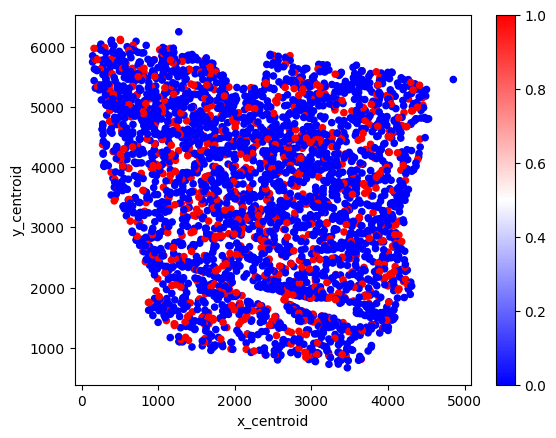

In [61]:
output.plot.scatter(
    x="x_centroid", 
    y="y_centroid",
    c=output["feature_19"].gt(0.5),
    cmap="bwr"
)

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


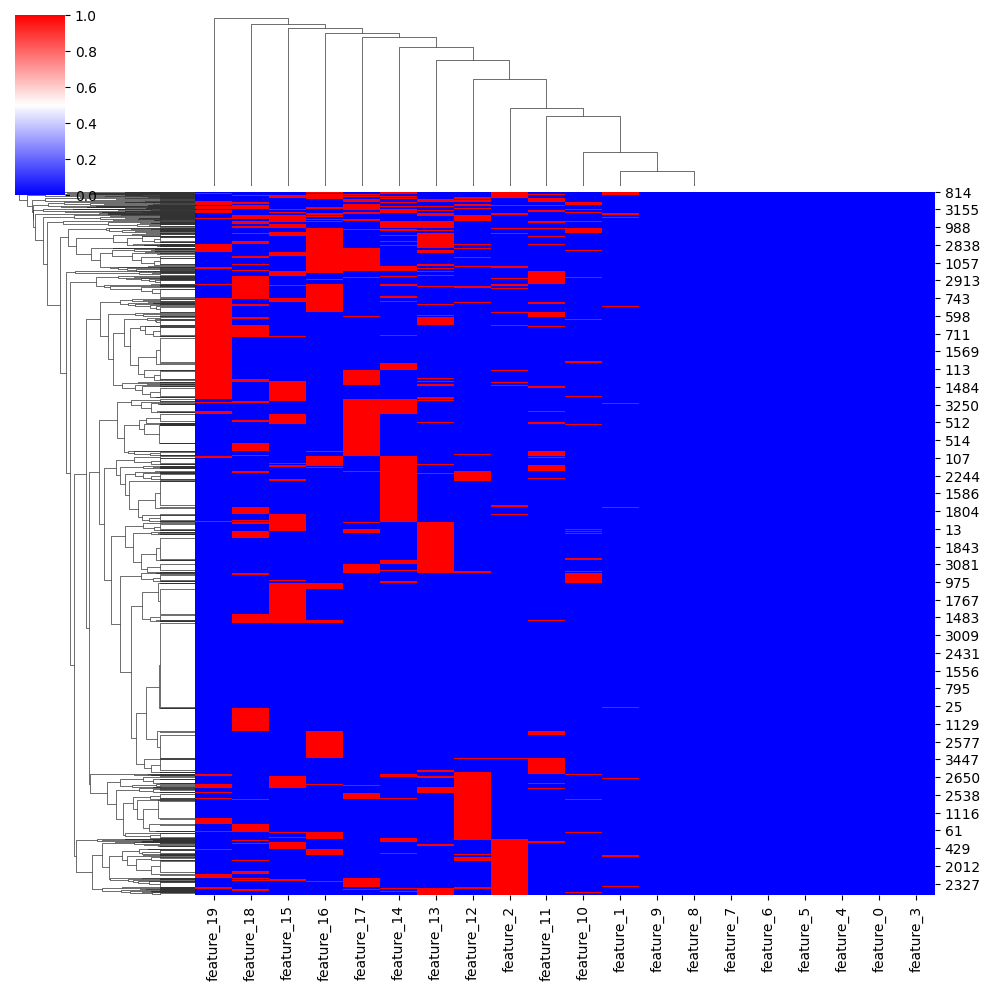

In [59]:
import seaborn as sns
sns.clustermap(np.clip(latent_features, -3, 3) > .5, metric="cityblock", method="average", cmap="bwr")

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,0.089381,-0.008209,0.398994,-0.031751,-0.012205,-0.974886,-3.0,-3.0,-3.0,-2.435199,0.472538,0.170329,-0.171887,-0.180824,0.684829,0.185950,-1.455128,0.051012,-0.651477,0.785255
1,-0.010366,-0.166923,0.071787,0.031990,0.051227,-0.396429,-3.0,-3.0,-3.0,-1.621348,-0.974986,0.232096,-0.130016,0.319417,-0.312752,0.353068,-0.630840,-0.356844,0.398672,-0.059894
2,-0.057859,0.526643,0.049791,-0.002094,0.106140,-0.754474,-3.0,-3.0,-3.0,-3.000000,0.029003,0.223199,-0.591558,1.829135,1.344155,0.130447,0.246711,0.803217,0.428862,-0.225039
3,0.003764,-0.042810,0.138818,0.024508,0.038399,-0.398973,-3.0,-3.0,-3.0,-2.284956,-0.099290,0.321107,-0.448364,-0.347244,1.098861,0.662316,0.100000,-1.033205,-0.513099,-0.144771
4,-0.116449,-0.188510,-0.080611,0.039392,0.049178,-0.579381,-3.0,-3.0,-3.0,-2.758559,-1.204640,0.214175,-1.254558,0.178470,0.238994,0.601284,0.884607,-0.276997,0.085257,-0.188607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564,-0.015533,0.149096,0.563062,-0.053211,0.015727,-0.358133,-3.0,-3.0,-3.0,-2.341688,-0.613582,-0.139050,-0.441952,-0.806124,0.059395,0.124914,1.322133,-0.313729,0.439161,0.566250
3565,-0.035797,-0.185492,0.267971,-0.038286,-0.007317,-0.391321,-3.0,-3.0,-3.0,-0.457915,-0.150964,-0.131405,-0.047921,-0.188690,0.248440,-0.827720,-0.249426,-0.009446,0.105343,0.437656
3566,0.008590,-0.056190,0.728155,-0.036226,-0.001231,-0.239443,-3.0,-3.0,-3.0,-2.827504,-1.612790,-1.553017,1.197455,0.877632,-0.430997,-0.265632,0.314109,-0.084307,0.366752,0.071684
3567,-0.102502,-0.244420,0.048140,-0.009532,0.017477,-0.936009,-3.0,-3.0,-3.0,-1.634654,0.490161,0.428478,0.063622,0.128005,0.419943,-0.957683,-0.942444,-0.465414,-0.530211,-0.035861
